In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import time

In [ ]:
dir_path = '/kaggle/input/hackathon/12_06_to_24_06'
files = sorted(os.listdir(dir_path))
progress = 0
df = pd.concat([pd.read_csv(os.path.join(dir_path, f)) for f in files ], ignore_index=True)
df.head()

In [ ]:
sensor_dic = {}   # map: sensor name -> sensor data
for sensor_name in df['MSR_Id'].unique():
    sensor_dic[sensor_name] = df.loc[df['MSR_Id'] == sensor_name].sort_values(by=['TimeStamp'])
    print(sensor_name, end=' ')

# DOWNLOAD SENSOR DATA

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
personal_token = user_secrets.get_secret('Git_Token')

In [3]:
!git clone https://{personal_token}@github.com/edoriggio/hackzurich-backend.git

Cloning into 'hackzurich-backend'...
remote: Enumerating objects: 926, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 926 (delta 26), reused 51 (delta 15), pack-reused 863
Receiving objects: 100% (926/926), 159.89 MiB | 23.66 MiB/s, done.
Resolving deltas: 100% (674/674), done.
Updating files: 100% (865/865), done.


In [4]:
!cd hackzurich-backend && git pull

Already up to date.


In [14]:
!cd hackzurich-backend/data/12* && ls

CH-0002.01.csv	CH-0149.01.csv	CH-0280.02.csv	CH-0370.02.csv	CH-0587.03.csv
CH-0002.02.csv	CH-0149.02.csv	CH-0280.03.csv	CH-0370.03.csv	CH-0587.04.csv
CH-0005.01.csv	CH-0149.03.csv	CH-0280.04.csv	CH-0370.04.csv	CH-0587.05.csv
CH-0005.02.csv	CH-0149.04.csv	CH-0280.05.csv	CH-0373.01.csv	CH-0587.06.csv
CH-0009.01.csv	CH-0149.05.csv	CH-0283.01.csv	CH-0373.02.csv	CH-0591.01.csv
CH-0009.02.csv	CH-0149.06.csv	CH-0283.02.csv	CH-0374.01.csv	CH-0591.02.csv
CH-0010.01.csv	CH-0150.01.csv	CH-0283.03.csv	CH-0374.02.csv	CH-0598.01.csv
CH-0010.02.csv	CH-0150.02.csv	CH-0283.04.csv	CH-0374.03.csv	CH-0598.02.csv
CH-0014.01.csv	CH-0157.01.csv	CH-0283.05.csv	CH-0374.04.csv	CH-0598.03.csv
CH-0014.02.csv	CH-0157.02.csv	CH-0283.06.csv	CH-0377.01.csv	CH-0598.04.csv
CH-0016.01.csv	CH-0162.01.csv	CH-0284.01.csv	CH-0377.02.csv	CH-0598.05.csv
CH-0016.02.csv	CH-0162.02.csv	CH-0284.02.csv	CH-0377.03.csv	CH-0598.06.csv
CH-0017.01.csv	CH-0162.03.csv	CH-0284.03.csv	CH-0377.04.csv	CH-0598.07.csv
CH-0017.02.csv	CH-0162.04

In [5]:
!wget https://bithackzurich2023.blob.core.windows.net/data/SensorLocationMetaData.csv

--2023-09-17 05:37:27--  https://bithackzurich2023.blob.core.windows.net/data/SensorLocationMetaData.csv
Resolving bithackzurich2023.blob.core.windows.net (bithackzurich2023.blob.core.windows.net)... 52.239.251.164
Connecting to bithackzurich2023.blob.core.windows.net (bithackzurich2023.blob.core.windows.net)|52.239.251.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157177 (153K) [text/csv]
Saving to: ‘SensorLocationMetaData.csv’

SensorLocationMetaD 100%[===================>] 153.49K   255KB/s    in 0.6s    

2023-09-17 05:37:28 (255 KB/s) - ‘SensorLocationMetaData.csv’ saved [157177/157177]



In [6]:
sensor_info = pd.read_csv('SensorLocationMetaData.csv', engine='python', encoding='latin-1', sep=';').dropna()
sensor_info.drop(['Direction.1', 'Canton', 'Name'], inplace=True, axis=1)
sensor_info.rename(columns={'Street ': 'Street'}, inplace=True)
sensor_info.loc[sensor_info['Street'].str.contains('A', case=False, na=False), 'Street'] = 'A'
sensor_info.loc[sensor_info['Street'].str.contains('H', case=False, na=False), 'Street'] = 'H'

sensor_info['Lane'] = sensor_info.Lane.apply(lambda x: float(x.split('lane')[1]) if 'lane' in x else float('nan'))

sensor_info.head()

sensor_info.sort_values(by='MSR_Id')

,MSR_Id,Lane,Direction,Latitude,Longitude,Street
1103,CH:0002.01,1.0,positive,46.575088,6.724624,H
1,CH:0002.02,1.0,negative,46.575150,6.724621,H
2,CH:0003.01,1.0,negative,46.105080,8.698175,H
1159,CH:0003.02,1.0,positive,46.105061,8.698230,H
884,CH:0005.01,1.0,positive,47.000172,9.076118,H
...,...,...,...,...,...,...
777,CH:0853.04,1.0,positive,47.157791,7.270669,A
1773,CH:0857.01,1.0,negative,46.748676,7.602260,A
1774,CH:0857.02,1.0,negative,46.748684,7.602320,A
1209,CH:0858.01,2.0,positive,46.763184,7.593775,A


# READ CSV AND CLE

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
dir_path = 'hackzurich-backend/data/12_06_to_24_06'
df = pd.read_csv(os.path.join(dir_path, 'CH-0005.02.csv'))
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16011 entries, 0 to 16010
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MSR_Id      16011 non-null  object 
 1   TimeStamp   16011 non-null  object 
 2   CarFlow     15989 non-null  float64
 3   LorryFlow   15989 non-null  float64
 4   AnyFlow     15989 non-null  float64
 5   CarSpeed    11409 non-null  float64
 6   LorrySpeed  869 non-null    float64
 7   AnySpeed    0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 1000.8+ KB


,MSR_Id,TimeStamp,CarFlow,LorryFlow,AnyFlow,CarSpeed,LorrySpeed,AnySpeed
0,CH:0005.02,2023-06-12T18:24:00.000000Z,60.0,0.0,0.0,56.000000,NaN,NaN
1,CH:0005.02,2023-06-12T18:25:00.000000Z,240.0,0.0,0.0,59.000000,NaN,NaN
2,CH:0005.02,2023-06-12T18:26:00.000000Z,120.0,0.0,0.0,56.500000,NaN,NaN
3,CH:0005.02,2023-06-12T18:27:00.000000Z,120.0,0.0,0.0,43.500000,NaN,NaN
4,CH:0005.02,2023-06-12T18:28:00.000000Z,180.0,0.0,0.0,58.299999,NaN,NaN


In [10]:
df['CarFlow'] = df['CarFlow'].interpolate()
df['LorryFlow'] = df['LorryFlow'].interpolate()
df['AnyFlow'] = df['AnyFlow'].interpolate()
df = df.fillna(0)

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df['Hour'] = df['TimeStamp'].apply(lambda x: x.hour)
df['Minute'] = df['TimeStamp'].apply(lambda x: x.minute)
df['Day'] = df['TimeStamp'].apply(lambda x: x.weekday())
df['Lane'] = sensor_info.loc[sensor_info['MSR_Id'] == df['MSR_Id'][0]].Lane.values[0]

In [11]:
df.head()

,MSR_Id,TimeStamp,CarFlow,LorryFlow,AnyFlow,CarSpeed,LorrySpeed,AnySpeed,Hour,Minute,Day,Lane
0,CH:0005.02,2023-06-12 18:24:00+00:00,60.0,0.0,0.0,56.000000,0.0,0.0,18,24,0,1.0
1,CH:0005.02,2023-06-12 18:25:00+00:00,240.0,0.0,0.0,59.000000,0.0,0.0,18,25,0,1.0
2,CH:0005.02,2023-06-12 18:26:00+00:00,120.0,0.0,0.0,56.500000,0.0,0.0,18,26,0,1.0
3,CH:0005.02,2023-06-12 18:27:00+00:00,120.0,0.0,0.0,43.500000,0.0,0.0,18,27,0,1.0
4,CH:0005.02,2023-06-12 18:28:00+00:00,180.0,0.0,0.0,58.299999,0.0,0.0,18,28,0,1.0


In [12]:
# generate dummies also for th days that are not present in this csv
possibilites = np.arange(7)
actual = df['Day'].unique()
additional = []
for x in possibilites:
    if x not in actual:
        additional.append(x)
dummy_values = pd.get_dummies(pd.concat((df['Day'], pd.Series(additional))))
dummy_values.drop(dummy_values.tail(len(additional)).index,inplace=True)
dummy_values.rename(columns = {0:'Day_0', 1:'Day_1', 2:'Day_2', 3:'Day_3', 4:'Day_4', 5:'Day_5', 6:'Day_6'}, inplace=True)
df.drop(['Day'], axis = 1, inplace = True)
df = pd.concat((df, dummy_values), axis=1)

In [13]:
df

,MSR_Id,TimeStamp,CarFlow,LorryFlow,AnyFlow,CarSpeed,LorrySpeed,AnySpeed,Hour,Minute,Lane,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,CH:0005.02,2023-06-12 18:24:00+00:00,60.0,0.0,0.0,56.000000,0.0,0.0,18,24,1.0,True,False,False,False,False,False,False
1,CH:0005.02,2023-06-12 18:25:00+00:00,240.0,0.0,0.0,59.000000,0.0,0.0,18,25,1.0,True,False,False,False,False,False,False
2,CH:0005.02,2023-06-12 18:26:00+00:00,120.0,0.0,0.0,56.500000,0.0,0.0,18,26,1.0,True,False,False,False,False,False,False
3,CH:0005.02,2023-06-12 18:27:00+00:00,120.0,0.0,0.0,43.500000,0.0,0.0,18,27,1.0,True,False,False,False,False,False,False
4,CH:0005.02,2023-06-12 18:28:00+00:00,180.0,0.0,0.0,58.299999,0.0,0.0,18,28,1.0,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16006,CH:0005.02,2023-06-24 07:30:00+00:00,240.0,0.0,0.0,59.799999,0.0,0.0,7,30,1.0,False,False,False,False,False,True,False
16007,CH:0005.02,2023-06-24 07:31:00+00:00,660.0,0.0,0.0,61.799999,0.0,0.0,7,31,1.0,False,False,False,False,False,True,False
16008,CH:0005.02,2023-06-24 07:32:00+00:00,360.0,0.0,0.0,60.200001,0.0,0.0,7,32,1.0,False,False,False,False,False,True,False
16009,CH:0005.02,2023-06-24 07:33:00+00:00,300.0,60.0,0.0,55.400002,51.0,0.0,7,33,1.0,False,False,False,False,False,True,False


# LSTM
MOST OF THIS CODE WAS TAKEN FROM https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output

In [14]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.models import Sequential
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
from tensorflow.keras.layers import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [18]:
features_considered = ['CarFlow', 'LorryFlow', 'CarSpeed', 'LorryFlow']
features = df[features_considered]
features.index = df['TimeStamp']
features.head()

,CarFlow,LorryFlow,CarSpeed,LorryFlow
TimeStamp,,,,
2023-06-12 18:24:00+00:00,60.0,0.0,56.000000,0.0
2023-06-12 18:25:00+00:00,240.0,0.0,59.000000,0.0
2023-06-12 18:26:00+00:00,120.0,0.0,56.500000,0.0
2023-06-12 18:27:00+00:00,120.0,0.0,43.500000,0.0
2023-06-12 18:28:00+00:00,180.0,0.0,58.299999,0.0


array([<Axes: xlabel='TimeStamp'>, <Axes: xlabel='TimeStamp'>,
       <Axes: xlabel='TimeStamp'>, <Axes: xlabel='TimeStamp'>],
      dtype=object)

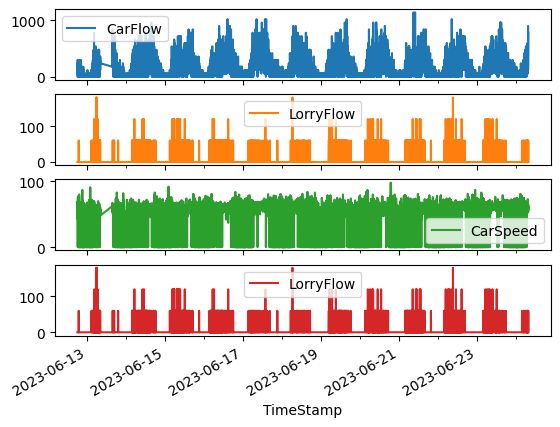

In [19]:
features.plot(subplots=True)

In [20]:
# Data Loader Parameters
BATCH_SIZE = 64
BUFFER_SIZE = 2000

dataset = features.values
TRAIN_SPLIT = int(0.8*dataset.shape[0])

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [21]:
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,CarFlow,LorryFlow,CarSpeed,LorryFlow
TimeStamp,,,,
2023-06-12 18:24:00+00:00,-0.595919,-0.229833,0.473094,-0.229833
2023-06-12 18:25:00+00:00,0.475539,-0.229833,0.581081,-0.229833
2023-06-12 18:26:00+00:00,-0.238766,-0.229833,0.491092,-0.229833
2023-06-12 18:27:00+00:00,-0.238766,-0.229833,0.023148,-0.229833
2023-06-12 18:28:00+00:00,0.118386,-0.229833,0.555884,-0.229833


In [22]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size=1):
    data = []
    labels = []

    if end_index is None:
        end_index = len(dataset) - history_size - target_size

    for i in range(start_index, end_index):
        indices = range(i, i+history_size)
        data.append(dataset[indices])
        labels.append(target[i+history_size:i+history_size+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns, ['b', 'r', 'g', 'y'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out), np.array(true_future[:,i]), c, markersize=5, alpha=0.1,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out), np.array(prediction[:,i]), 'o', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [23]:
x_train, y_train = multivariate_data(dataset, dataset, 0, TRAIN_SPLIT, 180, target_size=180)
x_val, y_val = multivariate_data(dataset, dataset, TRAIN_SPLIT, None, 180, target_size=180)

In [24]:
print (x_train.shape, y_train.shape,
       x_val.shape, y_val.shape)

(12808, 180, 4, 1, 1) (12808, 180, 4, 1, 1) (2843, 180, 4, 1, 1) (2843, 180, 4, 1, 1)


In [25]:
BATCH_SIZE = 128

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

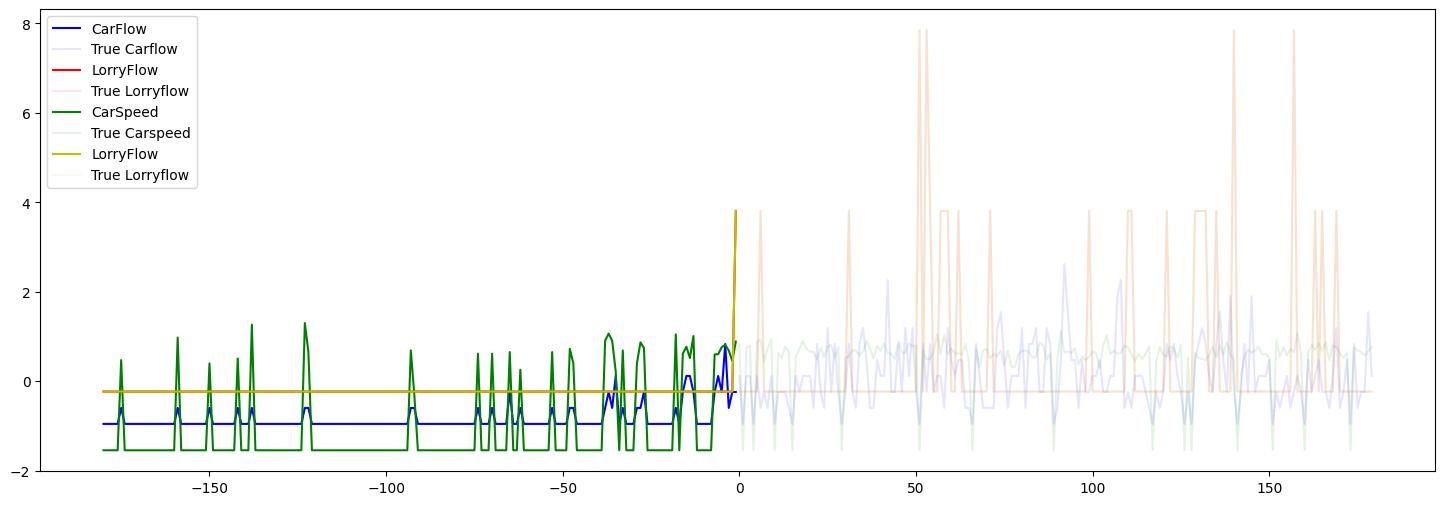

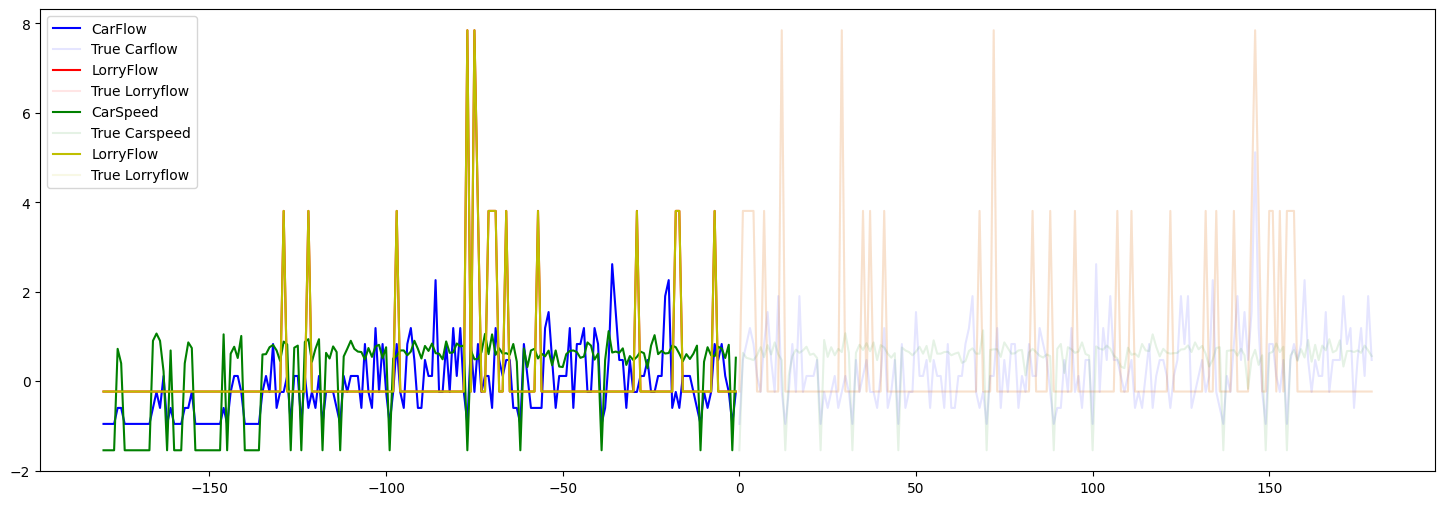

In [26]:
for x, y in val_data.take(2):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

In [34]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [38]:
# SINGLE GPU
EPOCHS = 10
PATIENCE = 5
steps_per_epoch = 250
validation_steps = 250
modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train.shape[1], 180, y_train.shape[2], x_train.shape[2])
# print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data,
                    epochs = EPOCHS,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


TRAIN MODEL...
Epoch 1/10


2023-09-16 21:58:03.999152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - 692s 3s/step - loss: 0.9338 - mae: 0.5881 - mse: 0.9338 - val_loss: 1.0519 - val_mae: 0.6706 - val_mse: 1.0519
Epoch 2/10
250/250 [==============================] - 634s 3s/step - loss: 0.8353 - mae: 0.5450 - mse: 0.8353 - val_loss: 1.0053 - val_mae: 0.6905 - val_mse: 1.0053
Epoch 3/10
250/250 [==============================] - 635s 3s/step - loss: 0.8224 - mae: 0.5222 - mse: 0.8224 - val_loss: 0.9806 - val_mae: 0.6391 - val_mse: 0.9806
Epoch 4/10
250/250 [==============================] - 633s 3s/step - loss: 0.7860 - mae: 0.5086 - mse: 0.7860 - val_loss: 0.9708 - val_mae: 0.6466 - val_mse: 0.9708
Epoch 5/10
250/250 [==============================] - 630s 3s/step - loss: 0.8131 - mae: 0.5092 - mse: 0.8131 - val_loss: 1.0229 - val_mae: 0.7038 - val_mse: 1.0229
Epoch 6/10
250/250 [==============================] - 629s 3s/step - loss: 0.7649 - mae: 0.4870 - mse: 0.7649 - val_loss: 0.9872 - val_mae: 0.5913 - val_mse: 0.9872
Epoch 7/10
250/250 [=

1/1 [==============================] - 1s 879ms/step


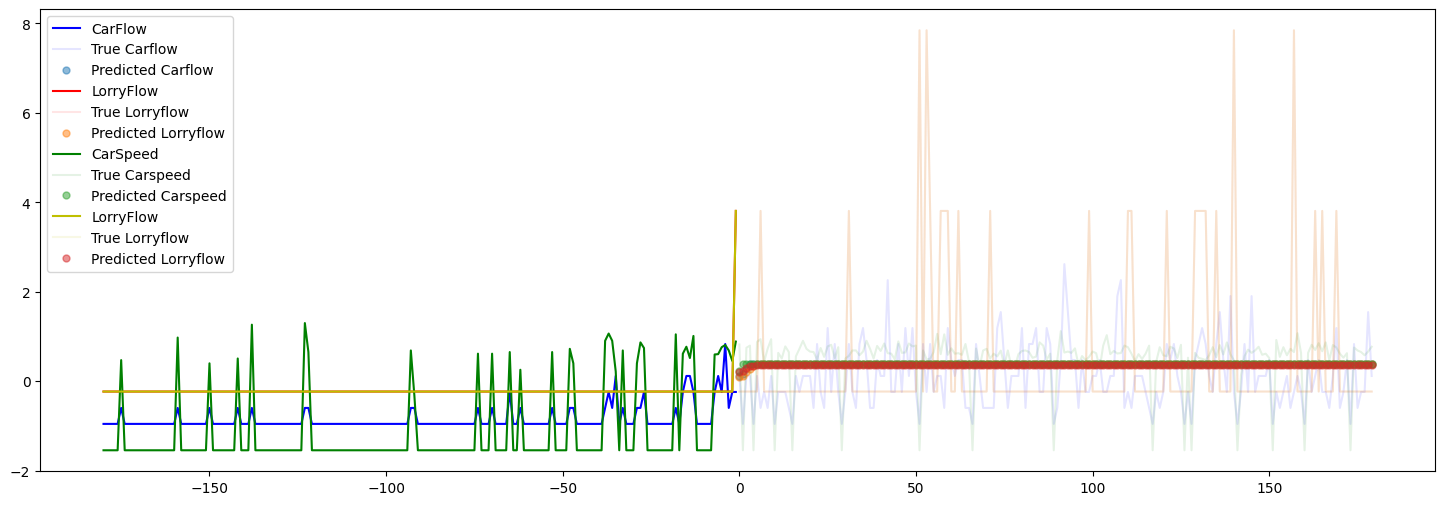

In [39]:
for x, y in val_data.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

In [45]:
!  git config --global user.email "miss@schween.org" && git config --global user.name "Melissa"

In [47]:
! ls hackzurich-backend/

README.md  app.py  data  dtos.py  multi-output-timesteps.h5  sensors_data


In [46]:
!cd hackzurich-backend/ && git add . && git commit -m "new data saved" && git push

[master f3e6a4a] new data saved
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 multi-output-timesteps.h5
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 2.17 MiB | 6.59 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/edoriggio/hackzurich-backend.git
   7650183..f3e6a4a  master -> master


In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import random
from datetime import datetime
from IPython.display import display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [33]:
# merging the files
joined_files = os.path.join("/kaggle/input/firsttestdata/4_09_from_2h30_to_5h30/", "*.csv")
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
  
# Finally, the files are joined
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
print(df)

            MSR_Id                    TimeStamp  CarFlow  LorryFlow  AnyFlow  \
0       CH:0542.05  2023-09-04T03:20:00.000000Z      0.0        0.0      0.0   
1       CH:0026.03  2023-09-04T03:20:00.000000Z     60.0        0.0      0.0   
2       CH:0301.03  2023-09-04T03:20:00.000000Z    600.0       60.0      0.0   
3       CH:0026.02  2023-09-04T03:20:00.000000Z    600.0      120.0      0.0   
4       CH:0301.02  2023-09-04T03:20:00.000000Z      0.0        0.0      0.0   
...            ...                          ...      ...        ...      ...   
324347  CH:0748.02  2023-09-04T01:00:00.000000Z      0.0        0.0      0.0   
324348  CH:0318.01  2023-09-04T01:00:00.000000Z     60.0        0.0      0.0   
324349  CH:0505.01  2023-09-04T01:00:00.000000Z    120.0        0.0      0.0   
324350  CH:0505.03  2023-09-04T01:00:00.000000Z      0.0        0.0      0.0   
324351  CH:0505.02  2023-09-04T01:00:00.000000Z      0.0        0.0      0.0   

          CarSpeed  LorrySpeed  AnySpee

In [34]:
def getDataofMSR(requestedMSR):
    reqVal = df.loc[df['MSR_Id'] == requestedMSR]
    reqVal.sort_values(['TimeStamp'])
    return reqVal

In [37]:
test_data = getDataofMSR('CH:0056.05')
print(test_data)

            MSR_Id                    TimeStamp  CarFlow  LorryFlow  AnyFlow  \
709     CH:0056.05  2023-09-04T03:20:00.000000Z    540.0      120.0      0.0   
2501    CH:0056.05  2023-09-04T03:23:00.000000Z    840.0        0.0      0.0   
4293    CH:0056.05  2023-09-04T02:01:00.000000Z     60.0        0.0      0.0   
6085    CH:0056.05  2023-09-04T01:57:00.000000Z     60.0        0.0      0.0   
7877    CH:0056.05  2023-09-04T02:03:00.000000Z    120.0        0.0      0.0   
...            ...                          ...      ...        ...      ...   
316101  CH:0056.05  2023-09-04T00:37:00.000000Z      0.0        0.0      0.0   
317893  CH:0056.05  2023-09-04T00:55:00.000000Z     60.0        0.0      0.0   
319685  CH:0056.05  2023-09-04T02:32:00.000000Z    120.0        0.0      0.0   
321477  CH:0056.05  2023-09-04T01:25:00.000000Z     60.0        0.0      0.0   
323269  CH:0056.05  2023-09-04T01:00:00.000000Z      0.0        0.0      0.0   

          CarSpeed  LorrySpeed  AnySpee

In [39]:
! ls hackzurich-backend/

README.md  app.py  data  dtos.py  multi-output-timesteps.h5  sensors_data


In [41]:
new_model = tf.keras.models.load_model('hackzurich-backend/multi-output-timesteps.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormaliz  (None, 180, 4, 1, 1)     4         
 ation)                                                          
                                                                 
 conv_lstm_1 (ConvLSTM2D)    (None, 4, 1, 64)          166656    
                                                                 
 dropout_1 (Dropout)         (None, 4, 1, 64)          0         
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 4, 1, 64)         256       
 ation)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 180, 256)        

In [42]:
for x, y in test_data.take(1):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

AssertionError: <class 'numpy.int64'>